### Import Libraries

In [55]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection

In [56]:
import warnings
warnings.filterwarnings("ignore")

In [57]:
data = pd.read_csv('datasets/IMDBDataset.csv')

In [58]:
data.columns

Index(['review', 'sentiment'], dtype='object')

In [59]:
data.shape

(50000, 2)

In [60]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Data Preprocessing:


In [61]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) 
sno = nltk.stem.SnowballStemmer('english') 

def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [ ]:
i=0
str1=' '
final_string=[]
all_positive_words=[] 
all_negative_words=[] 
s=''
for sent in data['review'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent) 
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (data['sentiment'].values)[i] == "positive": 
                        all_positive_words.append(s) 
                    if(data['sentiment'].values)[i] == "negative":
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) 
    
    final_string.append(str1)
    i+=1

In [9]:
data['cleaned_review']=final_string

In [15]:
def posneg(x):
    if x=="negative":
        return 0
    elif x=="positive":
        return 1
    return x

filtered_score = data["sentiment"].map(posneg)
data["score"] = filtered_score

In [16]:
test_data = data[:25000]
train_data = data[25000:50000]

In [17]:
X_train = train_data["cleaned_review"]
y_train = train_data["score"]

X_test = test_data["cleaned_review"]
y_test = test_data["score"]

In [18]:
y_train=y_train.astype('int')
y_test=y_test.astype('int')

### Data Representation:

In [19]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tf_idf_train = tf_idf_vect.fit_transform(X_train.values)
tf_idf_test = tf_idf_vect.transform(X_test.values)

### Naive Bayes:

In [20]:
alpha_range = list(np.arange(1,50,5))
len(alpha_range)

10

In [21]:
from sklearn.naive_bayes import MultinomialNB

alpha_scores=[]

for a in alpha_range:
    clf = MultinomialNB(alpha=a)
    scores = cross_val_score(clf, tf_idf_train, y_train, cv=5, scoring='accuracy')
    alpha_scores.append(scores.mean())
    print(a,scores.mean())

1 0.87836
6 0.8668799999999999
11 0.8626400000000001
16 0.85924
21 0.8562799999999999
26 0.8535599999999999
31 0.85176
36 0.8507999999999999
41 0.85036
46 0.8492799999999999


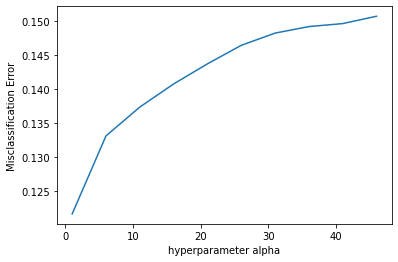

In [22]:
MSE = [1 - x for x in alpha_scores]


optimal_alpha_bnb = alpha_range[MSE.index(min(MSE))]

# plot misclassification error vs alpha
plt.plot(alpha_range, MSE)

plt.xlabel('hyperparameter alpha')
plt.ylabel('Misclassification Error')
plt.show()

In [23]:
optimal_alpha_bnb

1

In [24]:
clf = MultinomialNB(alpha=6)
clf.fit(tf_idf_train,y_train)

MultinomialNB(alpha=6)

In [25]:
y_pred_test = clf.predict(tf_idf_test)

In [26]:
acc = accuracy_score(y_test, y_pred_test, normalize=True) * float(100)
print('\n****Test accuracy is',(acc))


****Test accuracy is 87.236


In [27]:
cm_test = confusion_matrix(y_test,y_pred_test)
cm_test

array([[11146,  1380],
       [ 1811, 10663]], dtype=int64)

<AxesSubplot:>

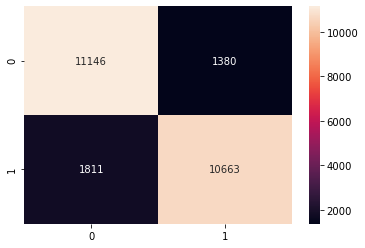

In [28]:
import seaborn as sns
sns.heatmap(cm_test,annot=True,fmt='d')

In [29]:
y_pred_train = clf.predict(tf_idf_train)

In [30]:
acc = accuracy_score(y_train, y_pred_train, normalize=True) * float(100)
print('\n****Train accuracy is %d%%' % (acc))


****Train accuracy is 93%


In [31]:
cm_train = confusion_matrix(y_train,y_pred_train)
cm_train

array([[11863,   611],
       [  924, 11602]], dtype=int64)

In [32]:
tn=11139;fn=1361;fp=2262;tp=10238;
n=tn+fp
p=fn+tp
print("total actual negative points %d"%(n))
print("total actual positive points %d"%(p))

total actual negative points 13401
total actual positive points 11599


In [33]:
tpr=tp/p
tnr=tn/n
fpr=fp/n
fnr=fn/p

print("TPR %f"%(tpr))
print("TNR %f"%(tnr))
print("FPR %f"%(fpr))
print("FNR %f"%(fnr))

TPR 0.882662
TNR 0.831207
FPR 0.168793
FNR 0.117338


In [34]:
precision=tp/(tp+fp)
print("Precision",precision)
recall = tp/p
print("Recall",recall)
f1 = 2*((precision*recall)/(precision+recall))
print("f1-score",f1)

Precision 0.81904
Recall 0.8826622984740063
f1-score 0.8496618116934312


In [35]:
total_positive_words = len(all_positive_words)
total_negative_words = len(all_negative_words)
print(total_positive_words)
print(total_negative_words)

2923508
2848517


In [36]:
type(all_positive_words)

list

In [37]:
import random
apw = random.sample(all_positive_words, 10000)
anw = random.sample(all_negative_words, 10000)

In [38]:
freq_negative_words = {x:anw.count(x) for x in anw}

In [39]:
freq_positive_words = {x:apw.count(x) for x in apw}

In [40]:
lst=[]
for key in freq_positive_words:
    prob = freq_positive_words[key]/total_positive_words
    lst.append([key,prob])
table_positive = pd.DataFrame(lst,columns=['positive_words','probability'])

In [41]:
table_positive = table_positive.sort_values('probability', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')


In [42]:
table_positive.head(10)


,positive_words,probability
69,b'film',0.000060
60,b'movi',0.000053
65,b'one',0.000034
195,b'like',0.000027
0,b'see',0.000022
16,b'great',0.000016
161,b'make',0.000016
138,b'good',0.000016
377,b'get',0.000016
91,b'charact',0.000015


In [45]:
from operator import itemgetter

posi={}
i=0
for key, value in sorted(freq_positive_words.items(), key = itemgetter(1), reverse = True):
    if(i>10):
        break
    posi[key]=value
    i+=1
posi

{b'film': 175,
 b'movi': 156,
 b'one': 98,
 b'like': 79,
 b'see': 63,
 b'great': 47,
 b'make': 47,
 b'good': 46,
 b'get': 46,
 b'stori': 45,
 b'love': 45}

In [46]:
lst=[]
for key in freq_negative_words:
    prob = freq_negative_words[key]/total_negative_words
    lst.append([key,prob])
table_negative = pd.DataFrame(lst,columns=['negative_words','probability'])

In [47]:
table_negative = table_negative.sort_values('probability', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')


In [48]:
table_negative.head(10)


,negative_words,probability
11,b'movi',0.000076
209,b'film',0.000054
363,b'like',0.000031
55,b'one',0.000031
158,b'would',0.000023
174,b'even',0.000021
290,b'good',0.000019
51,b'get',0.000019
37,b'time',0.000019
25,b'bad',0.000019


In [49]:
nega={}
i=0
for key, value in sorted(freq_negative_words.items(), key = itemgetter(1), reverse = True):
    if(i>10):
        break
    nega[key]=value
    i+=1
nega

{b'movi': 217,
 b'film': 153,
 b'like': 88,
 b'one': 87,
 b'would': 65,
 b'even': 59,
 b'good': 55,
 b'get': 54,
 b'bad': 53,
 b'time': 53,
 b'charact': 46}

BARPLOT FOR most frequent negative words


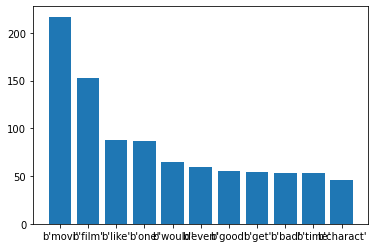

In [50]:
plt.bar(range(len(nega)), list(nega.values()), align='center')
plt.xticks(range(len(nega)), list(nega.keys()))

print("BARPLOT FOR most frequent negative words")
plt.show()

BARPLOT FOR most frequent positive words


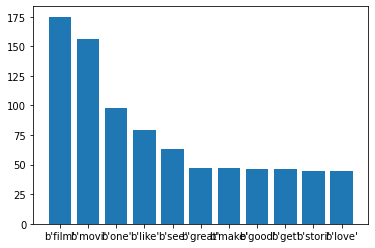

In [51]:
plt.bar(range(len(posi)), list(posi.values()), align='center')
plt.xticks(range(len(posi)), list(posi.keys()))

print("BARPLOT FOR most frequent positive words")
plt.show()